In [1]:
# Import necessary libraries
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from qpsolvers import solve_qp
from cvxopt import matrix
import quadrotor  # Assumed to contain A, B, and animate_robot

## Exercise 1 [20 points]

Consider the optimal control problem of Series 1 - Exercise 4 (control of a drone).

- Reusing the notebook of Series 1, write code to solve the same problem when the control is limited to $|5|$ for both rotors and the horizontal and vertical velocities are bounded to $2 \, \text{m} \cdot \text{s}^{-1}$. To solve the resulting QP, use the `cvxopt` solver available with the `qpsolvers` library.

- Show plots of all the states of the robot as a function of time.

- Show plots of the optimal control as a function of time.

- Compare the results with the results of Series 1 where no bounds were used.


<center><img src='quadrotor.png' width="700"></center>

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.


We want to generate a control input will move the drone towards the point $(3,3)$ starting from $(0,0)$. In order to
do so, we define a cost that penalizes the distance to the goal at each time step while minimizing velocities and the amount of trust needed,
i.e. we want to solve the following optimal control problem
$$\begin{align}
&\min_{x_0, u_0, x_1, u_1, \cdots} \frac{1}{2}\sum_{n=0}^{N} (x_n - x_{desired})^T Q (x_n - x_{desired}) + u_n^T R u_n\\
\textrm{subject to}\ \ & x_{n+1} = A x_{n} + B u_n\\
& x_0 = [0,0,0,0,0,0]^T\\
& x_{desired} = [3,0,3,0,0,0]^T\end{align}$$


This equation can be reformulateed as shown in the example: `Lexture 2- LQ Problems with KKT and QP.ipynb` as:

$$\begin{align}
    \notag \min_{x_0, u_0, x_1, u_1, \cdots} &\sum_{n=0}^{N} \left( \frac{1}{2} x_n^T Q x_n +  \frac{1}{2} u_n^T R u_n  - x_{desired}^T Q x_n\right) \\
    \notag \text{Subject to } x_{n+1} &= Ax_n + Bu_n \\
    \notag x_0 &= \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}^T \\
    \notag \text{Where, } x_{desired} &= \begin{bmatrix} 3 & 0 & 3 & 0 & 0 & 0 \end{bmatrix}^T
\end{align}$$

And the matrix equvalent form of the equation can be expressed as:

$$\begin{align}
\notag & \min_{y} \frac{1}{2} y^T G y + g^T y\\
\notag \textrm{subject to} \ \ \ \ & M y = p
\end{align}$$


where:

$$\begin{align}
    \notag &y = \begin{bmatrix} x_0 \\ u_0 \\ x_1 \\ u_1 \\ \vdots\end{bmatrix} && G = \begin{bmatrix} Q & 0 & 0 & 0 & \cdots\\ 0 & R & 0 & 0 & \cdots \\ 0 & 0 & Q & 0 & \cdots \\ 0 & 0 & 0 & R & \cdots \\ \vdots & \vdots & \vdots & \vdots & \ddots \end{bmatrix} &&& g = \begin{bmatrix} -x_{desired}^T Q\\  0\\ -x_{desired}^T Q\\ 0\\ \vdots\end{bmatrix} &&&& M = \begin{bmatrix} I & 0 & 0 & 0 & 0 & 0 & \cdots \\ A & B & -I & 0 & 0 & 0 & \cdots \\  0 & 0 & A & B & -I & 0 & \cdots \\  0 & 0 & 0 & 0 & A & B & \cdots \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \\ \end{bmatrix} &&&&& p = \begin{bmatrix} x_{0} \\ 0 \\ 0 \\ 0 \\ \vdots\end{bmatrix}
\end{align}
$$

In [2]:
# Define cost matrices
Q = np.diag([10, 1, 10, 1, 100, 1])  # State cost matrix (6x6)
R = np.diag([0.1, 0.1])               # Control cost matrix (2x_ineq)
xdim=6
udim=2
iterations=500
nvars = iterations*udim + (iterations+1)*xdim 
print("________________________________________________________")
print(f'Q =\n {Q}')
print("________________________________________________________")
print(f'R =\n {R}') 
print("________________________________________________________")
# the matrices A and B are already defined in the quadrotor module
print(f'A =\n {quadrotor.A}')
print("________________________________________________________")
print(f'B =\n {quadrotor.B}')
print("________________________________________________________")


________________________________________________________
Q =
 [[ 10   0   0   0   0   0]
 [  0   1   0   0   0   0]
 [  0   0  10   0   0   0]
 [  0   0   0   1   0   0]
 [  0   0   0   0 100   0]
 [  0   0   0   0   0   1]]
________________________________________________________
R =
 [[0.1 0. ]
 [0.  0.1]]
________________________________________________________
A =
 [[ 1.      0.01    0.      0.      0.      0.    ]
 [ 0.      1.      0.      0.     -0.0981  0.    ]
 [ 0.      0.      1.      0.01    0.      0.    ]
 [ 0.      0.      0.      1.      0.      0.    ]
 [ 0.      0.      0.      0.      1.      0.01  ]
 [ 0.      0.      0.      0.      0.      1.    ]]
________________________________________________________
B =
 [[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.02   0.02 ]
 [ 0.     0.   ]
 [ 0.015 -0.015]]
________________________________________________________


In [3]:
# Lets create our matrices namely G,g, M and p:
# ---------------------------------------------

Matrix=np.block([
[Q, np.zeros((6, 2))],
[np.zeros((2, 6)), R]])
Unit1=[Matrix]*iterations
G=(block_diag(*Unit1)).astype(np.float64) #G


    
M = np.hstack((np.eye(xdim), np.zeros(
    (xdim, (udim + ((xdim + udim) * (iterations - 1)))))))
for i in range(0, iterations-1):
    M_i = np.hstack((
        np.zeros((xdim, (i * (xdim + udim)))), 
        quadrotor.A,  
        quadrotor.B,  
        (-np.eye(xdim)),  
        
        np.zeros((xdim, (((xdim + udim) * (iterations - i - 1)) - xdim)))
    ))
    M = (np.vstack((M, M_i))).astype(np.float64)




g = np.tile(np.hstack((((-(np.array([3, 0, 3, 0, 0, 0]))) @ Q), [0]*udim)), iterations)
g = (g.reshape(g.shape[0], 1)).astype(np.float64)  # Reshape to a column vector

p = (np.zeros(((xdim*iterations), 1))).astype(np.float64)


The Lagrangian of the equations can be formed as, 
$$L\begin{equation} \notag
(y,\lambda) = \frac{1}{2} y^T G y + g^T y + \lambda^T (M y - p)
\end{equation}$$
and the KKT conditions is given as:
$$ \begin{bmatrix} G & M^T \\ M & 0 \end{bmatrix} \begin{pmatrix} y \\ \lambda \end{pmatrix} = \begin{pmatrix} -g \\ p \end{pmatrix}$$



Final State = [ 2.98906e+00 -3.13600e-02  3.00000e+00  0.00000e+00 -2.80000e-04
  2.65000e-03]
u : Max = 5.22619, Min = -1.98742
u_ineq : Max = 39.59207, Min = -6.83448


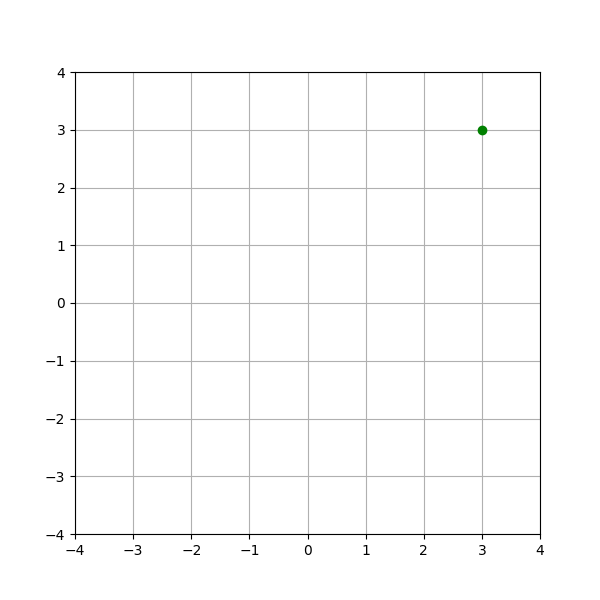

In [9]:
RHS=np.vstack((-g,p))
LHS=np.block([[G, M.T],[M, np.zeros((M.shape[0],M.shape[0]))]]) 
result=np.linalg.solve(LHS,RHS)

x = result[:4000].reshape(-1, 8)[:, :6].T
u = result[:4000].reshape(-1, 8)[:, 6:].T


print(f"\n\nFinal State = {np.round(x[:, iterations-1], 5)}")

# Print the maximum and minimum values of control input u
print(f"u : Max = {round(u[0].max(), 5)}, Min = {round(u[0].min(), 5)}")

# Print the maximum and minimum values of control input u_ineq
print(f"u_ineq : Max = {round(u[1].max(), 5)}, Min = {round(u[1].min(), 5)}")

# Animate the robot (quadrotor) using the computed states and controls
quadrotor.animate_robot(x, u, goal=[3, 3])

/home/jithin/Documents/optlearningcontrol-main/Homework/Series2/.venv/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


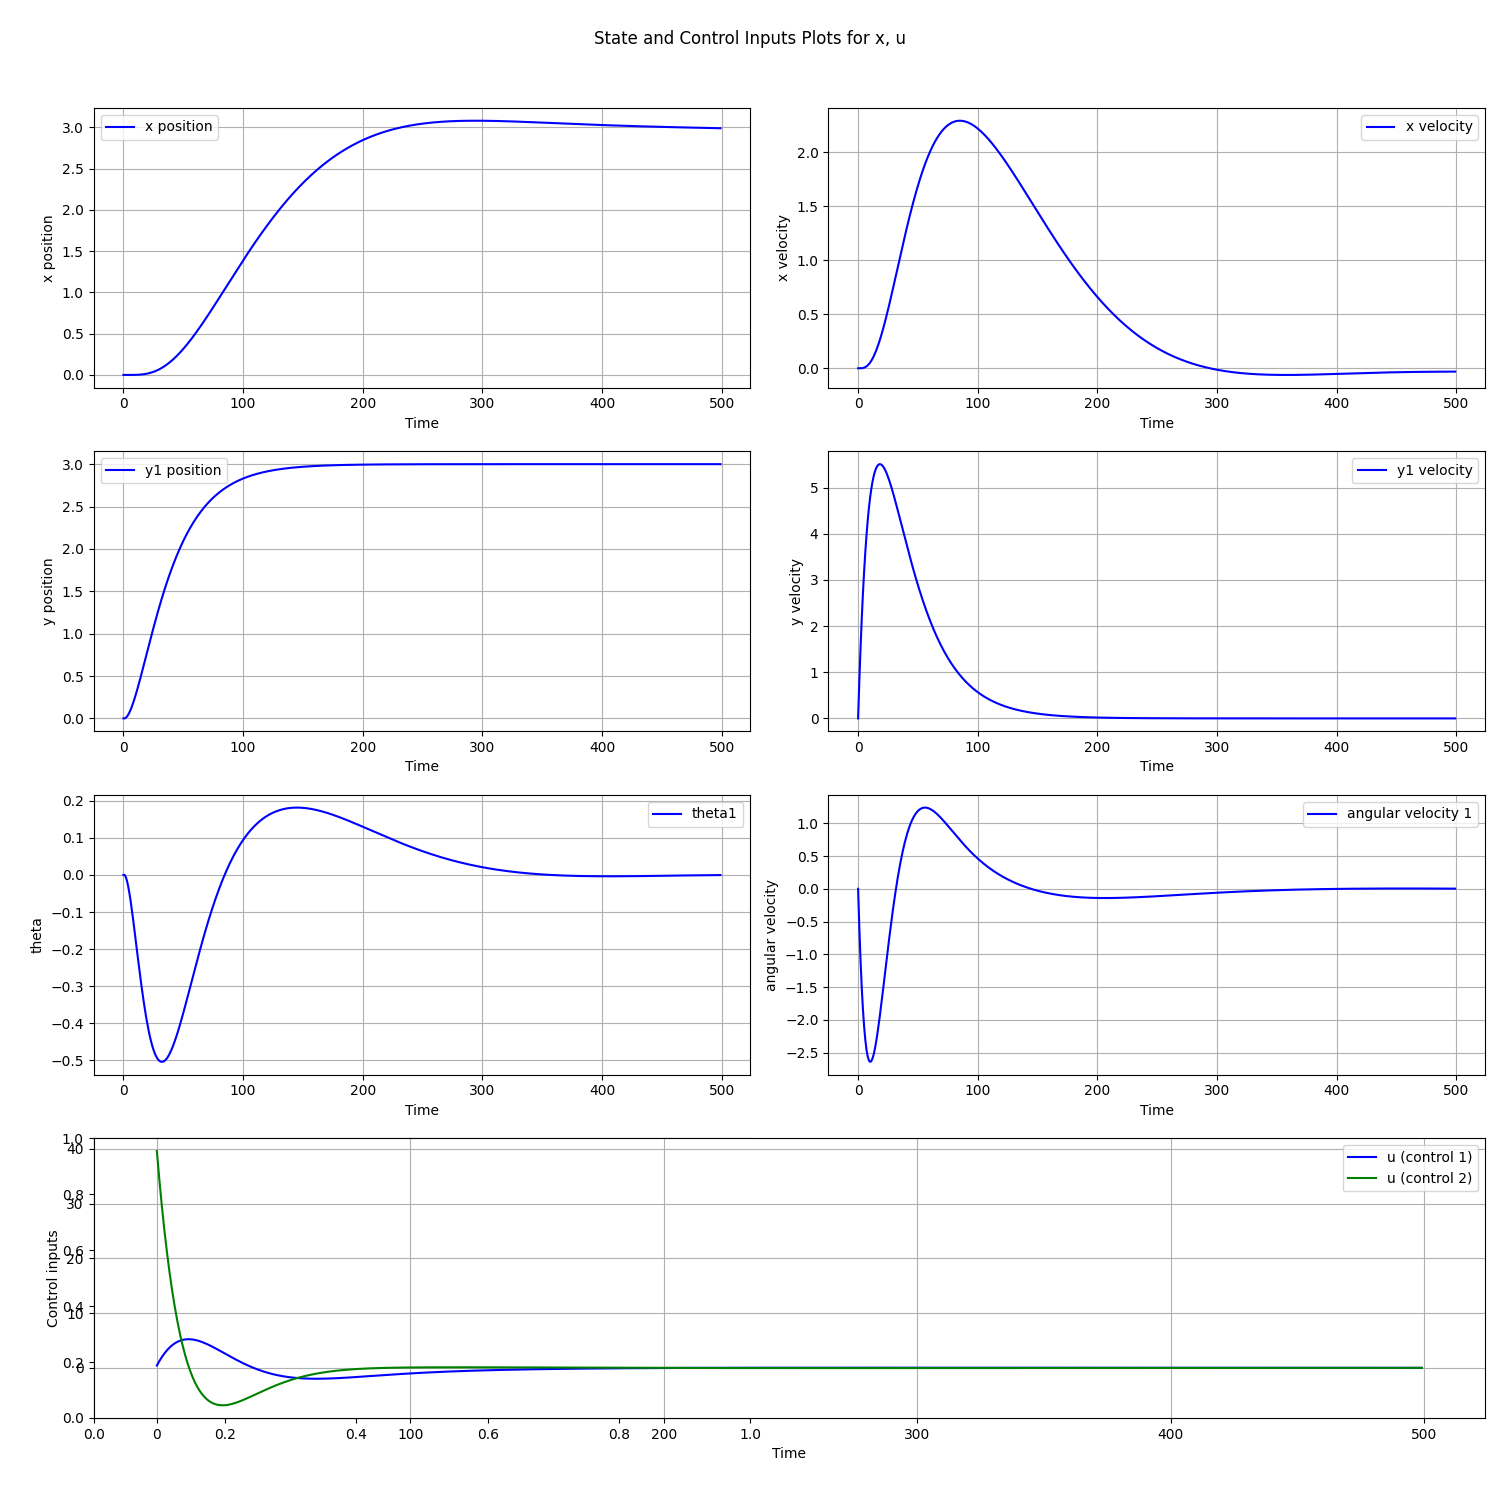

In [5]:
# Set the figure size
x_figsize = 15
y_figsize = 15
# Create a time array based on the number of columns in x
time = np.arange(x.shape[1])

# Create a single figure with a 4-row, 2-column layout
fig, axs = plt.subplots(4, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(f"State and Control Inputs Plots for x, u")

# Plot x position
axs[0, 0].plot(time, x[0, :], label='x position', color='blue')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('x position')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot x velocity
axs[0, 1].plot(time, x[1, :], label='x velocity', color='blue')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('x velocity')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot y position
axs[1, 0].plot(time, x[2, :], label='y1 position', color='blue')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('y position')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot y velocity
axs[1, 1].plot(time, x[3, :], label='y1 velocity', color='blue')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('y velocity')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot theta
axs[2, 0].plot(time, x[4, :], label='theta1', color='blue')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('theta')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot theta velocity
axs[2, 1].plot(time, x[5, :], label='angular velocity 1', color='blue')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('angular velocity')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Plot control inputs (u) in the fourth row, spanning both columns
axs[3, 0] = plt.subplot(4, 2, (7, 8))
axs[3, 0].plot(time, u[0, :], label='u (control 1)', color='blue')
axs[3, 0].plot(time, u[1, :], label='u (control 2)', color='green')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Control inputs')
axs[3, 0].legend()
axs[3, 0].grid(True)

# Remove the unused axis in the fourth row
fig.delaxes(axs[3, 1])

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Lets redo the problem comsidering the following inequality:



$$\begin{align}
    \notag & u_{min} \leq u_n \leq u_{max}  && \text{Where, } u_{min} = \begin{bmatrix} -5 & -5 \end{bmatrix}^T \quad \text{and} \quad u_{max} = \begin{bmatrix} 5 & 5 \end{bmatrix}^T\\
    \notag & x_{min} \leq x_n \leq x_{max} &&\text{Where, } x_{min} = \begin{bmatrix} 0 & -2 & 0 & -2 & 0 & 0 \end{bmatrix}^T \quad \text{and} \quad x_{max} = \begin{bmatrix} 0 & 2 & 0 & 2 & 0 & 0 \end{bmatrix}^T
\end{align}$$

The above equations can be rewritten as 
$\begin{align}
    \notag & -u_n \leq u_{min} && u_n \leq u_{max} \\ 
    \notag & -x_n \leq x_{min} && x_n\leq x_{max} 
\end{align}$

We can rewrite the above equations in matrix form as, 
$\begin{equation}
    \notag H y \leq h
\end{equation}$

Where, 
$\begin{align}
    \notag &H = \begin{bmatrix} 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots\\  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots\\  0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & \cdots\\  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & \cdots\\  0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & \cdots\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & \cdots\\  0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & \cdots\\  0 & 0 & 0 & 0 & 0 & 0 & 0 & 1& \cdots \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots\end{bmatrix} && y = \begin{bmatrix} x_0 \\ u_0 \\ x_1 \\ u_1 \\ \vdots\end{bmatrix} &&& h = \begin{bmatrix} 2 \\ 2 \\ 2 \\ 2 \\ 5 \\ 5 \\ 5 \\ 5 \\ \vdots\end{bmatrix}
\end{align}$



Thus we reformulate our equation as:
$$\begin{align}
\notag & \min_{y} \frac{1}{2} y^T G y + g^T y\\
\notag \textrm{Subject to \quad}  & M y = p \\
\notag & Hy \leq h
\end{align}$$

In [6]:
# Construct inequality constraints H and h
H_Matrix_i = np.array([
    # Adjust the rows to include the state constraints if necessary
    # For example, constraints on velocities and control inputs
    [0, -1, 0, 0, 0, 0, 0, 0],  # x velocity >= -2
    [0, 1, 0, 0, 0, 0, 0, 0],   # x velocity <= 2
    [0, 0, 0, -1, 0, 0, 0, 0],  # y velocity >= -2
    [0, 0, 0, 1, 0, 0, 0, 0],   # y velocity <= 2
    [0, 0, 0, 0, 0, 0, -1, 0],  # u1 >= -5
    [0, 0, 0, 0, 0, 0, 1, 0],   # u1 <= 5
    [0, 0, 0, 0, 0, 0, 0, -1],  # u_ineq >= -5
    [0, 0, 0, 0, 0, 0, 0, 1]    # u_ineq <= 5
], dtype=np.float64)

Unit2 = [H_Matrix_i] * iterations
H_Block = block_diag(*Unit2)

# h should be adjusted accordingly
h_Matrix_i = np.array([
    [2],
    [2],
    [2],
    [2],
    [5],
    [5],
    [5],
    [5]
], dtype=np.float64)
h = np.tile(h_Matrix_i, (iterations, 1))




print(f"P shape: {G.shape}")  # Expected: (4006, 4006)
print(f"g shape: {g.shape}")  # Expected: (4006,)
print(f"H_Block shape: {H_Block.shape}")  # Expected: (4000, 4006)
print(f"h shape: {h.shape}")  # Expected: (4000,)
print(f"M shape: {M.shape}")  # Expected: (3006, 4006)
print(f"p shape: {p.shape}")  # Expected: (3006,)

# Now, call solve_qp with correctly shaped and typed arguments
result_ineq = solve_qp(
    P=G,
    q=g,
    G=H_Block,
    h=h,
    A=M,
    b=p,
    solver='cvxopt',
    verbose=True
)








P shape: (4000, 4000)
g shape: (4000, 1)
H_Block shape: (4000, 4000)
h shape: (4000, 1)
M shape: (3000, 4000)
p shape: (3000, 1)
     pcost       dcost       gap    pres   dres
 0: -3.7100e+04 -1.8491e+05  4e+05  1e+00  3e-15
 1: -3.6422e+04 -9.5575e+04  7e+04  8e-02  4e-15
 2: -3.6539e+04 -4.3725e+04  7e+03  8e-03  3e-15
 3: -3.6711e+04 -3.7621e+04  9e+02  5e-04  2e-15
 4: -3.6745e+04 -3.6860e+04  1e+02  1e-05  2e-15
 5: -3.6747e+04 -3.6836e+04  9e+01  9e-06  3e-15
 6: -3.6750e+04 -3.6759e+04  9e+00  7e-07  2e-15
 7: -3.6750e+04 -3.6753e+04  3e+00  2e-07  3e-15
 8: -3.6750e+04 -3.6750e+04  3e-01  8e-09  2e-15
 9: -3.6750e+04 -3.6750e+04  4e-03  7e-11  2e-15
Optimal solution found.


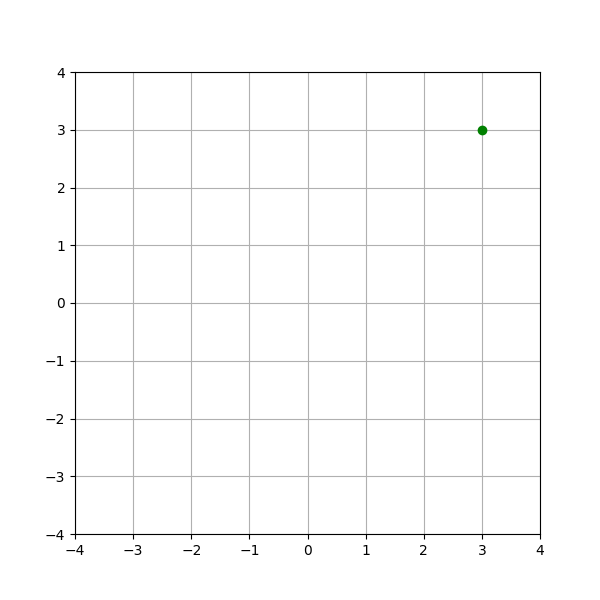

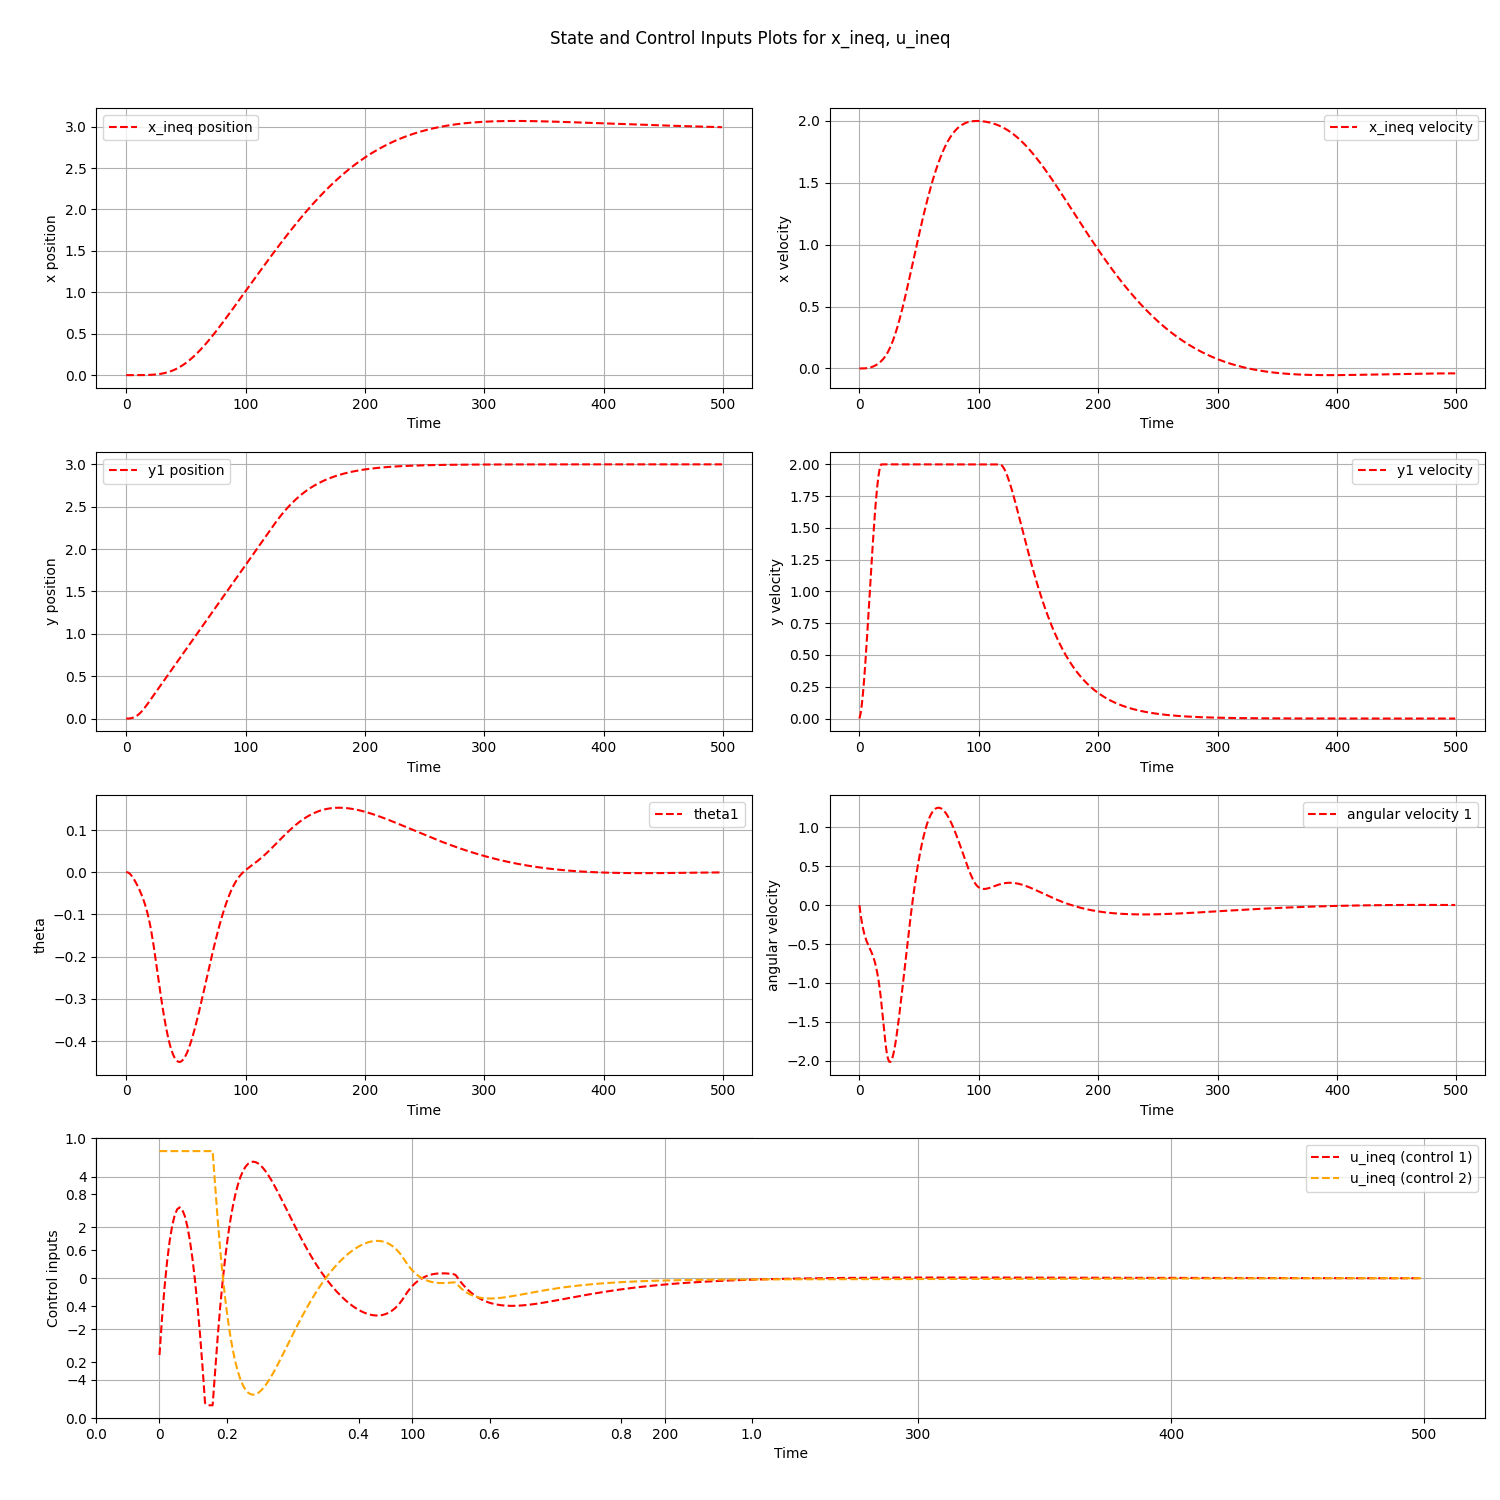

In [7]:
x_ineq = result_ineq[:4000].reshape(-1, 8)[:, :6].T
u_ineq = result_ineq[:4000].reshape(-1, 8)[:, 6:].T

quadrotor.animate_robot(x_ineq, u_ineq, goal=[3, 3])

# Set the figure size
x_figsize = 15
y_figsize = 15
# Create a time array based on the number of columns in x_ineq
time = np.arange(x_ineq.shape[1])

# Create a single figure with a 4-row, 2-column layout
fig, axs = plt.subplots(4, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(f"State and Control Inputs Plots for x_ineq, u_ineq")

# Plot x position
axs[0, 0].plot(time, x_ineq[0, :], label='x_ineq position',
               linestyle='--', color='red')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('x position')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot x velocity
axs[0, 1].plot(time, x_ineq[1, :], label='x_ineq velocity',
               linestyle='--', color='red')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('x velocity')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot y position
axs[1, 0].plot(time, x_ineq[2, :], label='y1 position',
               linestyle='--', color='red')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('y position')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot y velocity
axs[1, 1].plot(time, x_ineq[3, :], label='y1 velocity',
               linestyle='--', color='red')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('y velocity')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot theta
axs[2, 0].plot(time, x_ineq[4, :], label='theta1', linestyle='--', color='red')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('theta')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot theta velocity
axs[2, 1].plot(time, x_ineq[5, :], label='angular velocity 1',
               linestyle='--', color='red')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('angular velocity')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Plot control inputs (u_ineq) in the fourth row, spanning both columns
axs[3, 0] = plt.subplot(4, 2, (7, 8))
axs[3, 0].plot(time, u_ineq[0, :], label='u_ineq (control 1)',
               linestyle='--', color='red')
axs[3, 0].plot(time, u_ineq[1, :], label='u_ineq (control 2)',
               linestyle='--', color='orange')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Control inputs')
axs[3, 0].legend()
axs[3, 0].grid(True)

# Remove the unused axis in the fourth row
fig.delaxes(axs[3, 1])

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

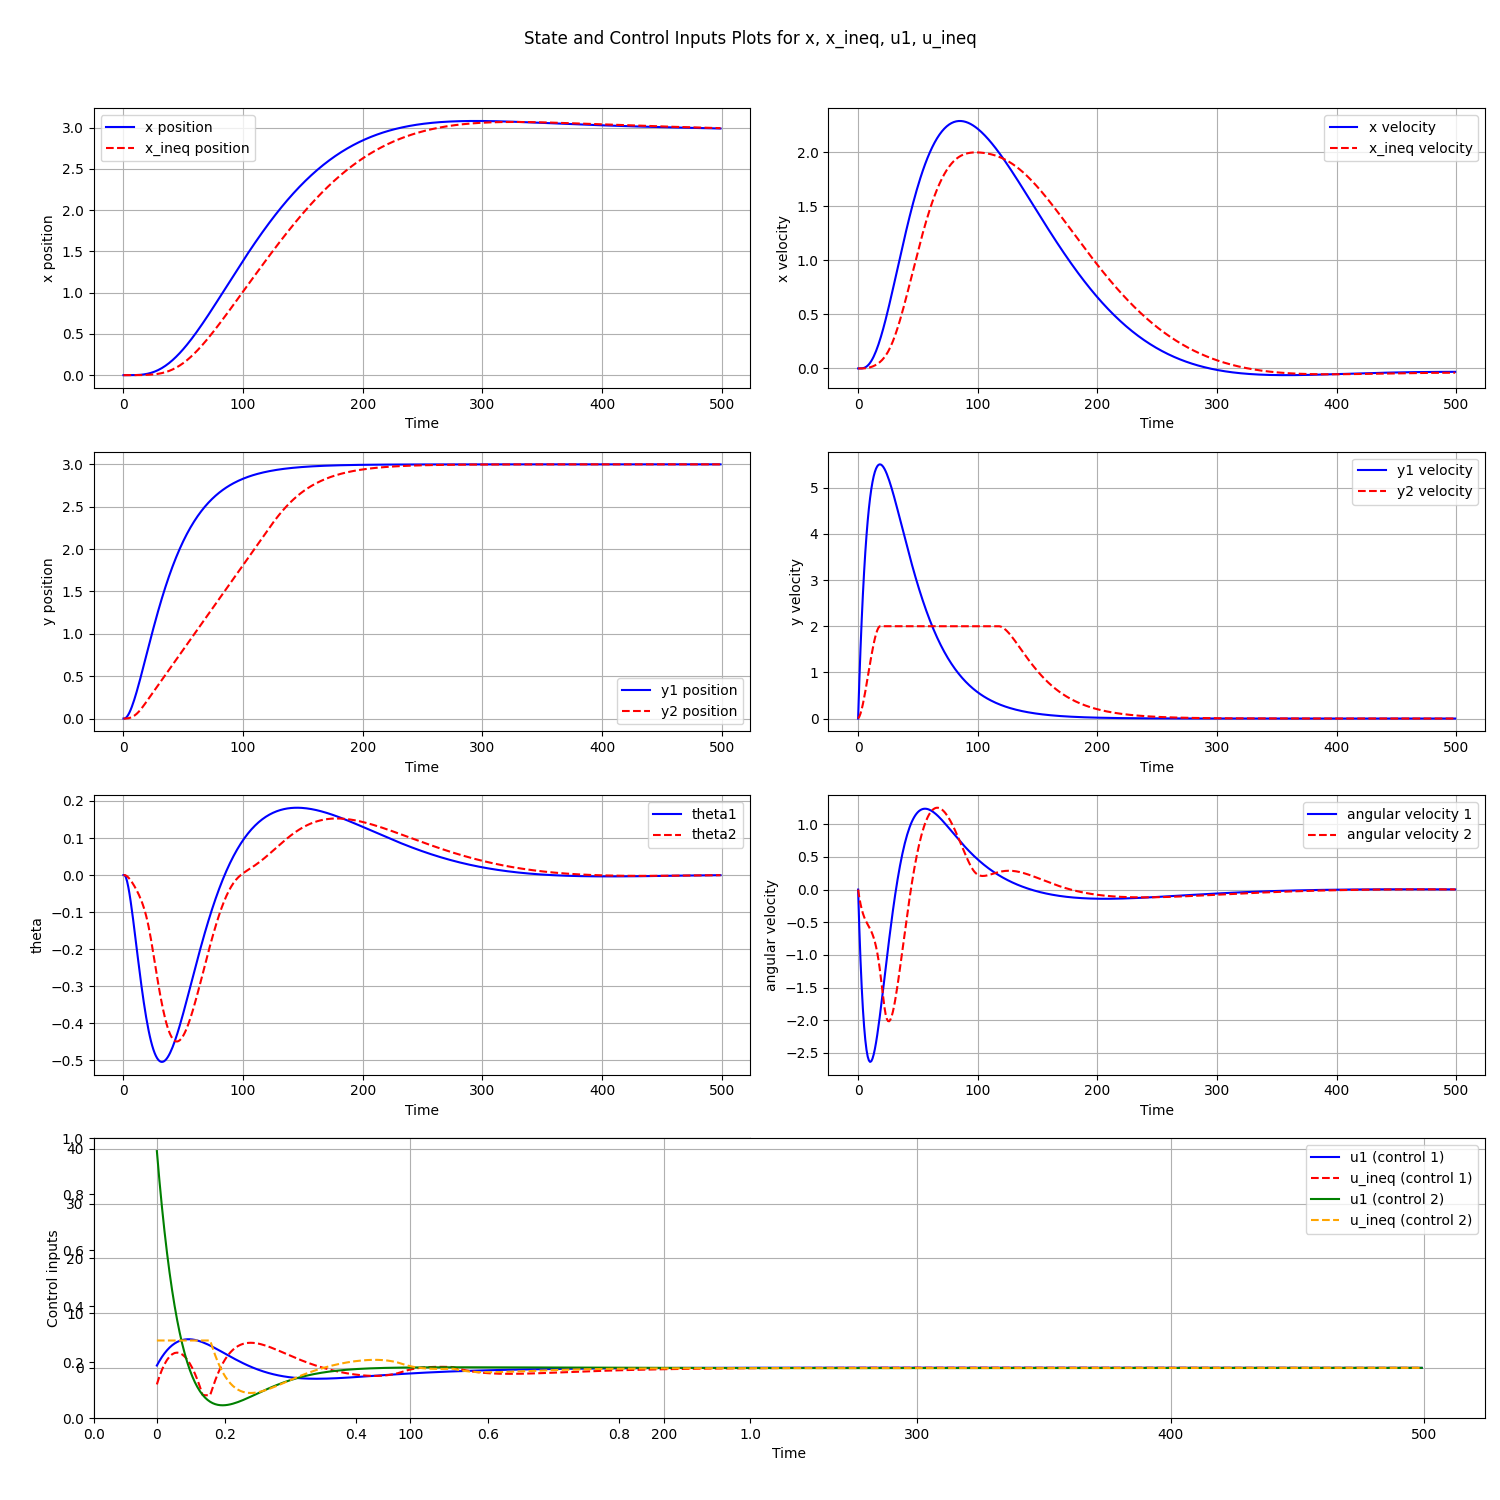

In [10]:

# Set the figure size
x_figsize = 15
y_figsize = 15
# Create a time array based on the number of columns in x or x_ineq
time = np.arange(x.shape[1])

# Create a single figure with a 4-row, 2-column layout
fig, axs = plt.subplots(4, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(f"State and Control Inputs Plots for x, x_ineq, u1, u_ineq")

# Plot x position
axs[0, 0].plot(time, x[0, :], label='x position', color='blue')
axs[0, 0].plot(time, x_ineq[0, :], label='x_ineq position',
               linestyle='--', color='red')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('x position')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot x velocity
axs[0, 1].plot(time, x[1, :], label='x velocity', color='blue')
axs[0, 1].plot(time, x_ineq[1, :], label='x_ineq velocity',
               linestyle='--', color='red')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('x velocity')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot y position
axs[1, 0].plot(time, x[2, :], label='y1 position', color='blue')
axs[1, 0].plot(time, x_ineq[2, :], label='y2 position',
               linestyle='--', color='red')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('y position')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot y velocity
axs[1, 1].plot(time, x[3, :], label='y1 velocity', color='blue')
axs[1, 1].plot(time, x_ineq[3, :], label='y2 velocity',
               linestyle='--', color='red')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('y velocity')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot theta
axs[2, 0].plot(time, x[4, :], label='theta1', color='blue')
axs[2, 0].plot(time, x_ineq[4, :], label='theta2', linestyle='--', color='red')
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('theta')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot theta velocity
axs[2, 1].plot(time, x[5, :], label='angular velocity 1', color='blue')
axs[2, 1].plot(time, x_ineq[5, :], label='angular velocity 2',
               linestyle='--', color='red')
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('angular velocity')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Plot control inputs (u1 and u_ineq) in the fourth row, spanning both columns
axs[3, 0] = plt.subplot(4, 2, (7, 8))
axs[3, 0].plot(time, u[0, :], label='u1 (control 1)', color='blue')
axs[3, 0].plot(time, u_ineq[0, :], label='u_ineq (control 1)',
               linestyle='--', color='red')
axs[3, 0].plot(time, u[1, :], label='u1 (control 2)', color='green')
axs[3, 0].plot(time, u_ineq[1, :], label='u_ineq (control 2)',
               linestyle='--', color='orange')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Control inputs')
axs[3, 0].legend()
axs[3, 0].grid(True)

# Hide the unused subplot (4th row, 2nd column) as we are using only one big plot for u1 and u_ineq
fig.delaxes(axs[3, 1])

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()